# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import scod
import pandas as pd
import numpy as np
from tqdm import trange
import evidential_deep_learning as edl
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data
import scod
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import trange
from scipy.stats.stats import pearsonr   

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_15732\651353948.py:19: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Scod Usage Example

In [3]:
class OneDDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, fn=np.sin, split='train') -> None:
        super().__init__()
        if split == 'train':
            np.random.seed(1001)
        elif split == 'val':
            np.random.seed(2001)
        else:
            np.random.seed(3001)
        x = np.concatenate([-1.5 + np.random.rand(N//2), 0.5 + np.random.rand(N - N//2)])[:,None]
        y = fn(((x+3)/2)**2)
        noise_std = np.abs(0.05*x**2)
        noise = noise_std*np.random.randn(N,1)

        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y + noise).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,:])


In [88]:
meanvar_model = torch.nn.Sequential(
    torch.nn.Linear(1, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)
meanvar_dist_layer = scod.distributions.NormalMeanDiagVarParamLayer()
model = torch.nn.Sequential(meanvar_model, meanvar_dist_layer)

mean_loss=-1.212804: 100%|██████████| 200/200 [00:02<00:00, 97.54it/s] 


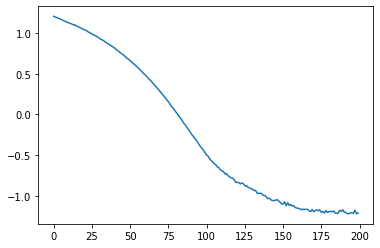

In [95]:
dataset = OneDDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=36, shuffle=True,  num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
t = trange(200)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()

        dist = model(inputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss

        optimizer.step()

    epoch_loss /= len(train_dataloader)

    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [96]:
X = np.linspace(-3.,3.,200)
xx_tensor = torch.from_numpy(X).view(-1,1).float()
dist = model(xx_tensor)
yhat = dist.mean.detach().cpu().numpy()[:,0]

In [97]:
meanvar_unc_model = scod.SCOD(meanvar_model, args={
    'num_eigs': 10,
    'num_samples': 64,
    'sketch_type': 'srft',
})
meanvar_unc_model.process_dataset(dataset, meanvar_dist_layer)

Weight space dimension: 8.578e+03
computing basis
using T = 64


  0%|          | 0/100 [00:00<?, ?it/s]

In [98]:
settings = [
    {   
        'name': 'ReLU MeanVar output',
        'model': meanvar_unc_model,
        'dist_layer': meanvar_dist_layer,
    },
]

In [99]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(xx_tensor)
    
    marg_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_var)
    z_var = z_var[:,:1]


    _, z_prior_var = scod_model(xx_tensor, use_prior=True)
    marg_prior_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_prior_var)
    z_prior_var = z_prior_var[:,:1]

    z_mean_dataset, _ = scod_model(dataset.X)
    z_mean_dataset = z_mean_dataset[:,:1]
    sq_err = (dataset.Y - z_mean_dataset)**2

    result = {
        'name': setting['name'],
        'z_vars': z_var.detach().cpu().numpy().reshape(X.shape),
        'total_var': marg_dist.variance.detach().cpu().numpy().reshape(X.shape),
        'prior_z_vars': z_prior_var.detach().cpu().numpy().reshape(X.shape),
        'total_prior_var': marg_prior_dist.variance.detach().cpu().numpy().reshape(X.shape),
        'sq_err' : sq_err.detach().cpu().numpy()
    }
    
    results.append(result)

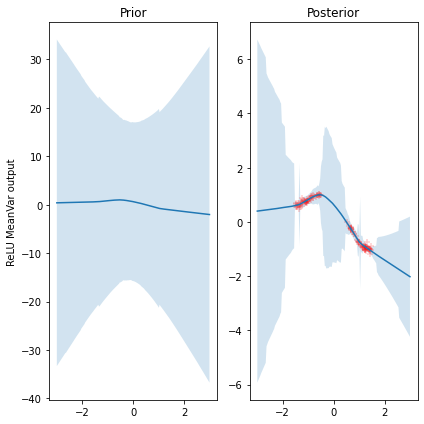

In [100]:
fig, axes = plt.subplots(len(results), 2, figsize=[6,6])

draw_y = True

for i, result in enumerate(results):
    std = np.sqrt(result['total_prior_var'])
    axes[0].fill_between(X, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
    axes[0].plot(X, draw_y*yhat)
    # axes[i,0].scatter(dataset.X[:,0], draw_y*dataset.Y)
    std = np.sqrt(result['total_var'])
    axes[1].fill_between(X, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
    axes[1].plot(X, draw_y*yhat)
    axes[1].scatter(dataset.X[:,0], draw_y*dataset.Y, marker='+', alpha=0.2, color='red')
    
    axes[0].set_ylabel(result['name'])

axes[0].set_title('Prior')
axes[1].set_title('Posterior')

plt.tight_layout()
#plt.savefig("qualitative_1d.pdf")

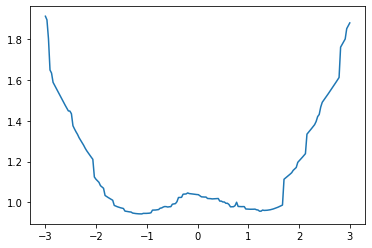

In [87]:
plt.plot(X,std)

# MyCode

## Rotated MNIST dataset

### Download Dataset

In [2]:
from rotated_mnist import RotatedMNIST
# Create a training dataset of rotated MNIST digits (where digit 2 is used by default)
rotated_mnist_train = RotatedMNIST(split='train')

# Create a validation dataset
rotated_mnist_val = RotatedMNIST(split='val')

# Create an out-of-distribution dataset
rotated_mnist_ood = RotatedMNIST(split='ood')

# Create an out-of-distribution dataset with a different angle
rotated_mnist_ood_angle = RotatedMNIST(split='ood_angle')


### Train and Evaluate Model Without Uncertainty

In [47]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from nn_ood.data.rotated_mnist import RotatedMNIST
from torchvision import transforms

In [48]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=5./3)
    if m.__class__.__name__.find('Conv') != -1:
        nn.init.normal_(m.weight, 0.0, 0.02)

In [49]:
def make_model():
    model = nn.Sequential(
        nn.Conv2d(1, 16, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, 3, 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(288, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    model.apply(weight_init)
    
    return model

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = make_model().to(device)

In [51]:
BATCH_SIZE = 16
N_EPOCHS = 10
LEARNING_RATE = 0.001

In [52]:
# Create the data loaders
train_loader = DataLoader(rotated_mnist_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(rotated_mnist_val, batch_size=BATCH_SIZE, shuffle=False)

In [53]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [54]:
# Training loop
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    print(f'Validation Loss: {val_loss/len(val_loader)}')


Epoch 1, Loss: 0.27534147578693585
Validation Loss: 0.24117859773910963
Epoch 2, Loss: 0.19117883237293515
Validation Loss: 0.13807913643809466
Epoch 3, Loss: 0.17056767477206985
Validation Loss: 0.17871360583947254
Epoch 4, Loss: 0.16475725611397152
Validation Loss: 0.17228106672947224
Epoch 5, Loss: 0.15773376878900278
Validation Loss: 0.1151881936364449
Epoch 6, Loss: 0.13013453372621825
Validation Loss: 0.1246875666655027
Epoch 7, Loss: 0.14279162600366824
Validation Loss: 0.11808782732830597
Epoch 8, Loss: 0.13484339711653323
Validation Loss: 0.10232469320583802
Epoch 9, Loss: 0.11431794508232987
Validation Loss: 0.11841874697174017
Epoch 10, Loss: 0.1109566256134264
Validation Loss: 0.10755628228474122


In [55]:
# Save the trained model
torch.save(model.state_dict(), "RotatedMNIST_model_basic.pth")

In [56]:
# create a function to evaluate the mean absolute error
def evaluate_mae(model, dataloader):
    model.eval()
    criterion = nn.L1Loss()
    with torch.no_grad():
        mae = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            mae += criterion(outputs.squeeze(), targets).item()
    return mae / len(dataloader)
mae = evaluate_mae(model, DataLoader(rotated_mnist_val, batch_size=BATCH_SIZE))
print(mae)


0.22565277551229185


### Use SCOD

In [16]:
from nn_ood.distributions import GaussianFixedDiagVar

In [17]:
# from nn_ood.posteriors import SCOD
from scod import SCOD

In [18]:
from rotated_mnist import RotatedMNIST

In [20]:
def make_model():
    model = nn.Sequential(
        nn.Conv2d(1, 16, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, 3, 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(288, 10),
        nn.ReLU(),
        nn.Linear(10, 2)
    )
    model.apply(weight_init)
    
    return model

In [21]:
# load "RotatedMNIST_model.pth in model
model = make_model().to(device)
meanvar_dist_layer = scod.distributions.NormalMeanDiagVarParamLayer()
model = torch.nn.Sequential(model, meanvar_dist_layer)

  0%|          | 0/10 [00:00<?, ?it/s]

mean_loss=42.769417: 100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


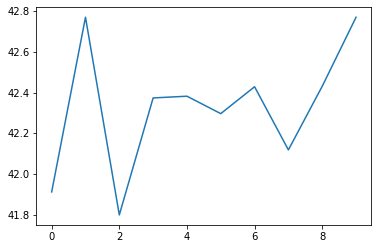

In [36]:
train_dataloader = torch.utils.data.DataLoader(rotated_mnist_train, batch_size=36, shuffle=True,  num_workers=0)
val_loader = torch.utils.data.DataLoader(rotated_mnist_val, batch_size=36, shuffle=False,  num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

losses = []
t = trange(10)

for epoch in t:
    model.train()
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()

        dist = model(inputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss

        optimizer.step()

    epoch_loss /= len(train_dataloader)

    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            # print("outputs", outputs)
            # print("targets", targets)
            # print("targets shape", targets.shape)
            # loss = criterion(outputs, targets)
            loss = -outputs.log_prob(targets)
            val_loss += loss.mean().item()
    val_loss /= len(val_loader)

plt.plot(losses)

In [25]:
test_loader = torch.utils.data.DataLoader(rotated_mnist_val, batch_size=36, shuffle=True,  num_workers=0)

In [38]:
model.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

In [40]:
outputs

Independent(Normal(loc: torch.Size([24, 1]), scale: torch.Size([24, 1])), 1)

In [41]:
yhat = outputs.mean.detach().cpu().numpy()[:,0]

In [42]:
yhat.shape

(24,)

In [43]:
unc_model = scod.SCOD(model, args={
    'num_eigs': 10,
    'num_samples': 64,
    'sketch_type': 'srft',
})

Weight space dimension: 1.696e+04


In [44]:
unc_model.process_dataset(val_loader, meanvar_dist_layer)

computing basis
using T = 64


  0%|          | 0/29 [00:00<?, ?it/s]

TypeError: 'DataLoader' object is not subscriptable

In [29]:
# Load your dataset
rotated_mnist_train = RotatedMNIST(split='train')

# Define your model (use the make_model function provided in the script)
model = make_model().to(device)

In [30]:
# Create the data loaders
train_loader = DataLoader(rotated_mnist_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(rotated_mnist_val, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
# Wrap it with SCOD
dist_fam = GaussianFixedDiagVar().to(device) # Assuming Gaussian distribution for regression
scod_model = SCOD(model, dist_fam).to(device)

TypeError: 'GaussianFixedDiagVar' object is not iterable

In [101]:
scod_model.process_dataset(rotated_mnist_train)

computing basis
using T = 64


100%|██████████| 5958/5958 [00:39<00:00, 149.73it/s]


In [34]:
rotated_mnist_val = RotatedMNIST(split='val')  # Or 'test', if available
val_loader = DataLoader(rotated_mnist_val, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
model.eval()  # Make sure the model is in evaluation mode

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=288, out_features=10, bias=True)
  (10): ReLU()
  (11): Linear(in_features=10, out_features=1, bias=True)
)

In [104]:
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)

        # Since SCOD wrapper expects inputs to have gradient, 
        # enable gradient computation for inputs if not already done
        inputs.requires_grad_(True)
        
        # Get predictions and uncertainty estimates
        prediction, uncertainty = scod_model(inputs)

        # Here, you can process the prediction and uncertainty as needed, for example:
        # Convert prediction and uncertainty to numpy or CPU tensors for further processing
        prediction = prediction.cpu().numpy()
        uncertainty = uncertainty.cpu().numpy()
        
        # Example of handling the results
        print(f"Prediction: {prediction}, Uncertainty: {uncertainty}")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

### Use Deep Evidential Regression

In [5]:
#Required losses to make use of Evidential

def NIG_NLL(y, gamma, v, alpha, beta, device, reduce=True):
    twoBlambda = 2*beta*(1+v)

    nll = 0.5*torch.log(torch.tensor(np.pi).to(device)/v)  \
        - alpha*torch.log(twoBlambda+1e-5)  \
        + (alpha+0.5) * torch.log(v*(y-gamma)**2 + twoBlambda+1e-5)  \
        + torch.lgamma(alpha)  \
        - torch.lgamma(alpha+0.5)

    return nll.mean() if reduce else nll

def KL_NIG(mu1, v1, a1, b1, mu2, v2, a2, b2):
    KL = 0.5*(a1-1)/b1 * (v2*torch.square(mu2-mu1))  \
        + 0.5*v2/v1  \
        - 0.5*torch.log(torch.abs(v2)/torch.abs(v1))  \
        - 0.5 + a2*torch.log(b1/b2)  \
        - (torch.lgamma(a1) - torch.lgamma(a2))  \
        + (a1 - a2)*torch.digamma(a1)  \
        - (b1 - b2)*a1/b1
    return KL

def NIG_Reg(y, gamma, v, alpha, beta, device, omega=0.01, reduce=True, kl=False):
    error = torch.abs(y-gamma).detach()
    if kl:
        kl = KL_NIG(gamma, v, alpha, beta, gamma, device, omega, 1+omega, beta)
        reg = error*kl
    else:
        evi = 2*v+(alpha) #+ 1/beta
        reg = error*evi

    return (reg).mean() if reduce else reg

def EvidentialRegression(y_true, gamma, v, alpha, beta, device ,coef=1.0,reduce=True):
    loss_nll = NIG_NLL(y_true, gamma, v, alpha, beta, device, reduce = reduce)
    loss_reg = NIG_Reg(y_true, gamma, v, alpha, beta, device, reduce = reduce)
    return loss_nll + coef * loss_reg

In [8]:
class ConvEvidentialRegressor(nn.Module):
    def __init__(self):
        super(ConvEvidentialRegressor, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels, Output channels, Kernel size
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Kernel size, Stride

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 64 output channels from conv2, image size is 7x7 after pooling
        self.fc2 = nn.Linear(128, 4)  # Output 4 evidential parameters: mu, v, alpha, beta

        # Evidence layer to ensure outputs are positive
        self.evidence = nn.Softplus()

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 7 * 7)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Split the output into evidential parameters and apply the evidence function
        mu, logv, logalpha, logbeta = torch.split(x, 1, dim=1)
        v = self.evidence(logv) + 1e-5
        alpha = self.evidence(logalpha) + 1 + 1e-5
        beta = self.evidence(logbeta) + 1e-5

        return mu, v, alpha, beta

# Example of creating a model instance
model = ConvEvidentialRegressor()

Epoch 20, Train Loss: 1.3810, Val Loss: 1.3439: 100%|██████████| 20/20 [02:47<00:00,  8.37s/it]


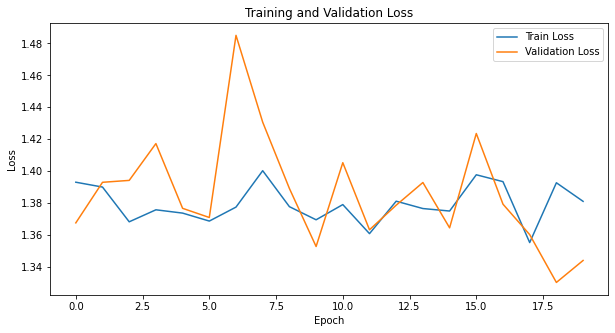

In [19]:
from torch.utils.data import DataLoader
from tqdm import trange
import torch.nn.functional as F

train_dataloader = DataLoader(rotated_mnist_train, batch_size=36, shuffle=True)
val_dataloader = DataLoader(rotated_mnist_val, batch_size=36, shuffle=False)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
losses = []
val_losses = []
t = trange(20)

for epoch in t:
    epoch_loss = 0.0
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()

        gamma_s, v_s, alpha_s, beta_s = model(inputs)
        loss = EvidentialRegression(targets, gamma_s, v_s, alpha_s, beta_s, device='cpu', coef=0.2)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    losses.append(epoch_loss)

    # Validation loop
    val_epoch_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            gamma_s, v_s, alpha_s, beta_s = model(inputs)
            val_loss = EvidentialRegression(targets, gamma_s, v_s, alpha_s, beta_s, device='cpu', coef=0.2)
            val_epoch_loss += val_loss.item()

    val_epoch_loss /= len(val_dataloader)
    val_losses.append(val_epoch_loss)

    t.set_description(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")

# Plotting the training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # Set the model to evaluation mode
test_loader = DataLoader(rotated_mnist_ood_angle, batch_size=32, shuffle=False)
total_nll = 0.0
total_count = 0

with torch.no_grad():  # Disable gradient computation
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Get model predictions
        gamma, v, alpha, beta = model(inputs)
        
        # Compute the predictive variance (or standard deviation)
        # Here we need the correct formula based on your model's output
        # This is a placeholder and needs to be adjusted based on your model
        sigma_squared = beta / (v * (alpha - 1))
        sigma = torch.sqrt(sigma_squared)
        
        # Compute the NLL
        nll = 0.5 * torch.log(2 * np.pi * sigma_squared) + ((targets - gamma) ** 2) / (2 * sigma_squared)
        total_nll += nll.sum().item()  # Sum NLL for batch and add to total
        total_count += inputs.size(0)  # Count total number of datapoints

average_nll = total_nll / total_count
print("Average NLL on OOD Test Set:", average_nll)


Average NLL on OOD Test Set: 152.7361945810244


## Wine

### Load datasets

In [2]:
red_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')
white_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=';')

### Use Deep Evidential Regression

In [456]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import evidential_deep_learning as edl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Splitting the data into features and target
X = red_wine.drop('quality', axis=1).values
y = red_wine['quality'].values.reshape(-1, 1)  # Regression targets must be 2D for TensorFlow

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the TensorFlow model
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        edl.layers.DenseNormalGamma(1),  # Output layer for evidential regression
    ])
    return model

# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

# Create the model instance
model = build_model(input_shape=(X_train_scaled.shape[1],))


In [457]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss=EvidentialRegressionLoss)

In [458]:
model.fit(X_train_scaled, y_train, batch_size=32, epochs=100, validation_split=0.1)

Epoch 1/100
36/36 [==============================] - 1s 7ms/step - loss: 5.2762 - val_loss: 4.2940
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 3.5890 - val_loss: 3.0514
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 2.7969 - val_loss: 2.5637
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 2.3463 - val_loss: 2.1229
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 2.0318 - val_loss: 1.9350
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 1.8868 - val_loss: 1.8298
Epoch 7/100
36/36 [==============================] - 0s 3ms/step - loss: 1.7924 - val_loss: 1.7741
Epoch 8/100
36/36 [==============================] - 0s 3ms/step - loss: 1.7189 - val_loss: 1.7125
Epoch 9/100
36/36 [==============================] - 0s 3ms/step - loss: 1.6550 - val_loss: 1.6800
Epoch 10/100
36/36 [==============================] - 0s 3ms/step - loss: 1.5924 - val_loss: 1.6363
Epoch 11/

In [459]:
y_pred = model.predict(X_test_scaled)

10/10 [==============================] - 0s 5ms/step


In [460]:
mu = y_pred[:, 0] # mean value predicted by the model

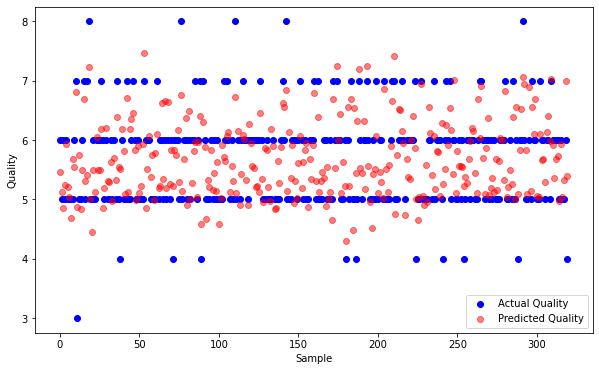

In [461]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Quality')
plt.scatter(range(len(mu)), mu, color='red', label='Predicted Quality', alpha=0.5)
plt.xlabel('Sample')
plt.ylabel('Quality')
plt.legend()
plt.show()

In [462]:
def plot_uncertainty(X_train, y_train, X_test, y_test, model):
    # Predict the evidential outputs using the model
    y_pred = model.predict(X_test_scaled)
    
    # Split the predictions into components
    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0].numpy()  # Convert to NumPy array and get the predicted mean
    var = np.sqrt(beta / (v * (alpha - 1))) # Convert to NumPy array and get the predicted variance
    var = np.minimum(var, 1e3)[:, 0]  # for visualization, cap the variance
    
    # Get the true quality scores as NumPy array for indexing
    y_test_np = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test
    
    # Sort the test data by the predicted mean for nicer plots
    sorted_indices = np.argsort(mu)
    mu_sorted = mu[sorted_indices]
    var_sorted = var[sorted_indices]
    y_test_sorted = y_test_np[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(y_test_sorted)), y_test_sorted, s=2., color='blue', zorder=0, label="True Quality")
    plt.scatter(range(len(mu_sorted)), mu_sorted, s=2., color='red', zorder=1, label="Predicted Quality")
    plt.fill_between(range(len(mu_sorted)), mu_sorted + 1.96 * var_sorted, mu_sorted - 1.96 * var_sorted, alpha=0.2, color='red', label="Predicted Std Dev")
    plt.xlabel("Sorted Test Data Points")
    plt.ylabel("Quality")
    plt.title("Wine Quality Predictions with Uncertainty")
    plt.legend()
    plt.show()


10/10 [==============================] - 0s 1ms/step


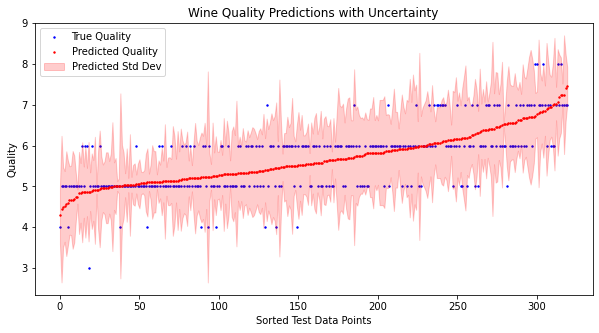

In [463]:
plot_uncertainty(X_train, y_train, X_test, y_test, model)

In [464]:
def plot_uncertainty_vs_error(X_test_scaled, y_test, model):
    # Predict the evidential outputs using the model
    y_pred = model.predict(X_test_scaled)
    
    # Split the predictions into components
    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0].numpy()  # Convert to NumPy array and get the predicted mean
    var = np.sqrt(beta / (v * (alpha - 1))) # Convert to NumPy array and get the predicted variance
    var = np.minimum(var, 1e3)[:, 0]  # for visualization, cap the variance
    
    # Get the true quality scores as NumPy array for indexing
    y_test_np = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test

    # transform y_test_np to 1D array
    y_test_np = y_test_np.flatten()

    pred_error = np.abs(y_test_np - mu)

    # Plot the correlation between the predicted standard deviation var and the prediction error (|y_test_np - mu|)
    plt.figure(figsize=(6, 6))
    plt.scatter(var, pred_error, s=2., color='blue', label="Uncertainty vs. Error")
    plt.xlabel("Predicted Standard Deviation")
    plt.ylabel("Prediction Error")
    plt.title("Uncertainty vs. Error")
    plt.show()

    return (var, pred_error)

10/10 [==============================] - 0s 1ms/step


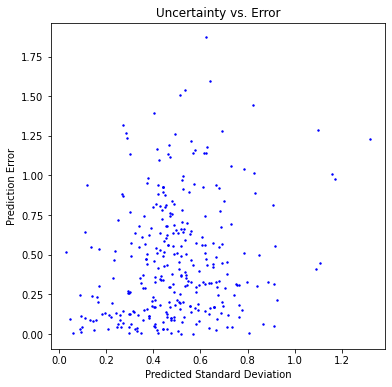

In [465]:
var, pred_error = plot_uncertainty_vs_error(X_test_scaled, y_test, model)

In [468]:
# compute the correlation between var and pred_error
print(pearsonr(var,pred_error))

(0.21159002873170707, 0.00013701761596873472)


In [473]:
nll_loss = 0.5 * np.log(2 * torch.pi * var) + (y_test - mu) ** 2 / (2 * var)
nll_loss = nll_loss.mean()

print(f'Negative Log Likelihood Loss on the Test Set of the Wine Dataset using Evidential Deep Learning: {nll_loss.item()}')

Negative Log Likelihood Loss on the Test Set of the Wine Dataset using Evidential Deep Learning: 1.9810665845870972


### Use Scod on full dataset

In [368]:
red_wine = red_wine.sample(frac=0.1).reset_index(drop=True)

In [369]:
features = red_wine.drop('quality', axis=1).values
targets = red_wine['quality'].values.reshape(-1, 1)

In [370]:
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(targets, dtype=torch.float32)

In [371]:
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

In [372]:
dataset_size = dataset.tensors[0].shape[1]

In [373]:
meanvar_model = torch.nn.Sequential(
    torch.nn.Linear(dataset_size, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)
meanvar_dist_layer = scod.distributions.NormalMeanDiagVarParamLayer()
model = torch.nn.Sequential(meanvar_model, meanvar_dist_layer)

mean_loss=1.065550: 100%|██████████| 200/200 [00:02<00:00, 70.16it/s]


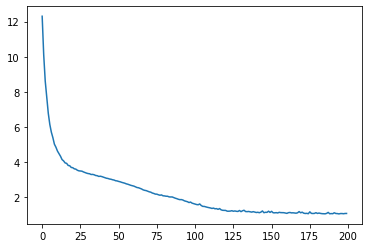

In [374]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=36, shuffle=True,  num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
t = trange(200)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()

        dist = model(inputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss

        optimizer.step()

    epoch_loss /= len(train_dataloader)

    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [375]:
dist = model(X_tensor)
yhat = dist.mean.detach().cpu().numpy()[:,0]

In [376]:
meanvar_unc_model = scod.SCOD(meanvar_model, args={
    'num_eigs': 10,
    'num_samples': 64,
    'sketch_type': 'srft',
})

Weight space dimension: 9.218e+03


In [377]:
meanvar_unc_model.process_dataset(dataset, meanvar_dist_layer)

computing basis
using T = 64


  0%|          | 0/160 [00:00<?, ?it/s]

C:\Users\Kelyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [378]:
settings = [
    {   
        'name': 'ReLU MeanVar output',
        'model': meanvar_unc_model,
        'dist_layer': meanvar_dist_layer,
    },
]

In [379]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(X_tensor) 
    
    marg_dist = meanvar_dist_layer.marginalize_gaussian(z_mean, z_var)
    z_var = z_var[:,:1]

    _, z_prior_var = scod_model(X_tensor, use_prior=True) # from full dataset
    print("z_mean shape:", z_mean.shape)
    print("z_prior_var shape:", z_prior_var.shape)
    marg_prior_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_prior_var)
    z_prior_var = z_prior_var[:,:1]

    z_mean_dataset, _ = scod_model(X_tensor)
    z_mean_dataset = z_mean_dataset[:,:1]
    sq_err = (y_tensor - z_mean_dataset)**2

    result = {
        'name': setting['name'],
        'z_vars': z_var.detach().cpu().numpy().reshape(X_tensor.shape[0]),
        'total_var': marg_dist.variance.detach().cpu().numpy().reshape(X_tensor.shape[0]),
        'prior_z_vars': z_prior_var.detach().cpu().numpy().reshape(X_tensor.shape[0]),
        'total_prior_var': marg_prior_dist.variance.detach().cpu().numpy().reshape(X_tensor.shape[0]),
        'sq_err' : sq_err.detach().cpu().numpy()
    }
    
    results.append(result)

z_mean shape: torch.Size([160, 2])
z_prior_var shape: torch.Size([160, 2])


In [380]:
features_list = red_wine.columns[:-1].tolist()

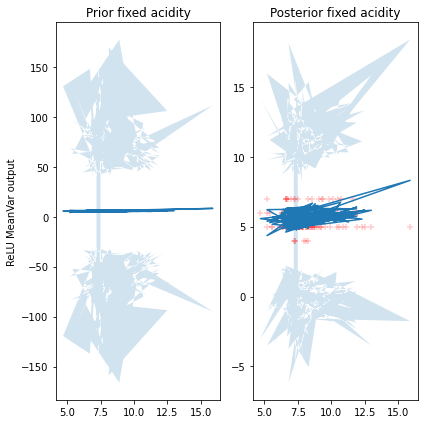

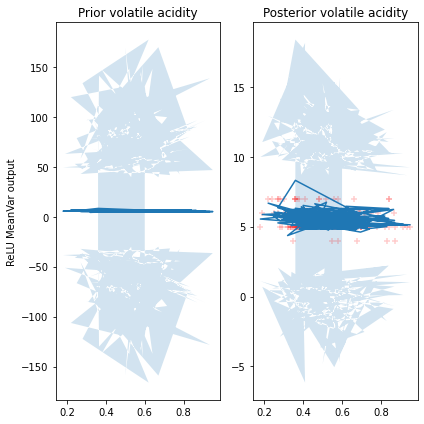

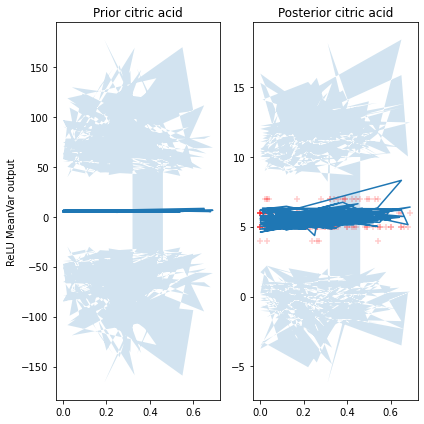

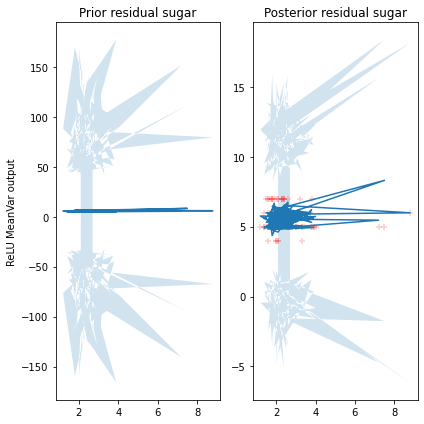

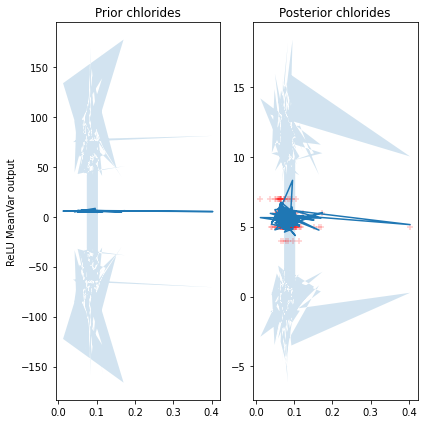

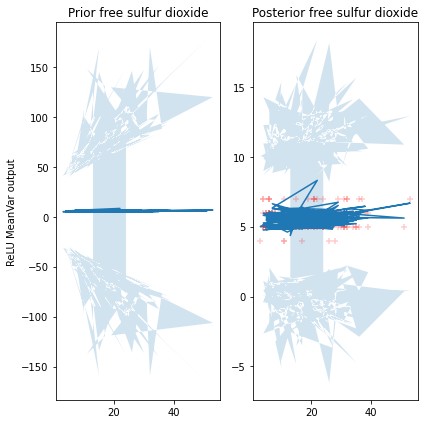

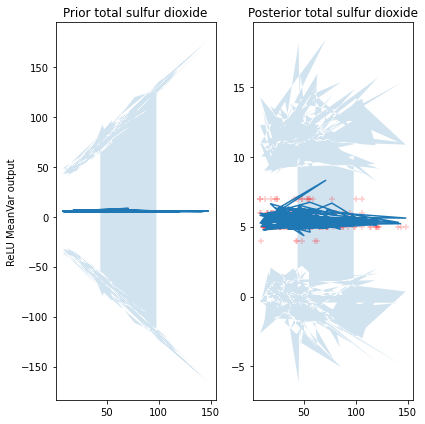

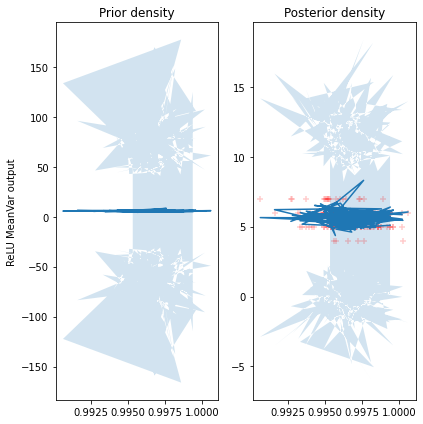

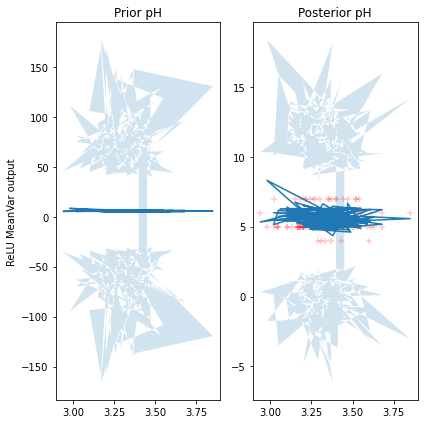

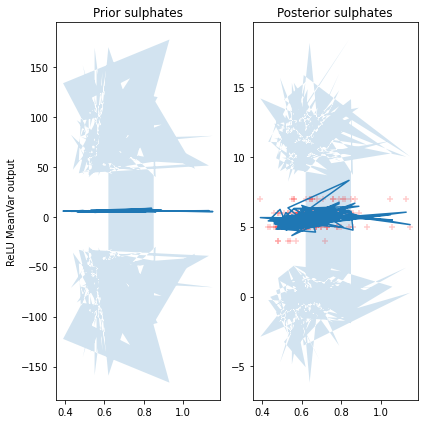

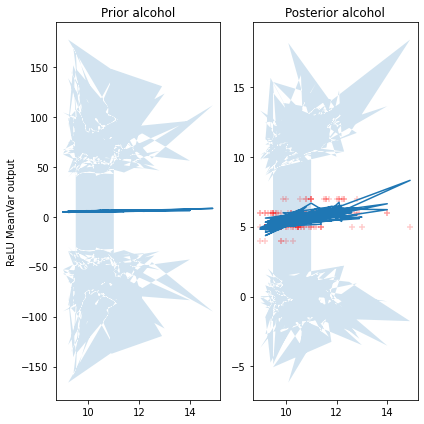

In [381]:
for i in range(len(features_list)):
    X_1dd = X_tensor[:, i]
    feature = features_list[i]
    fig, axes = plt.subplots(len(results), 2, figsize=[6,6])

    draw_y = True

    for i, result in enumerate(results):
        std = np.sqrt(result['total_prior_var'])
        axes[0].fill_between(X_1dd, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
        axes[0].plot(X_1dd, draw_y*yhat)
        std = np.sqrt(result['total_var'])
        axes[1].fill_between(X_1dd, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
        axes[1].plot(X_1dd, draw_y*yhat)
        axes[1].scatter(X_1dd, draw_y*y_tensor, marker='+', alpha=0.2, color='red')
        
        axes[0].set_ylabel(result['name'])

    axes[0].set_title('Prior ' + feature)
    axes[1].set_title('Posterior '+ feature)

    plt.tight_layout()

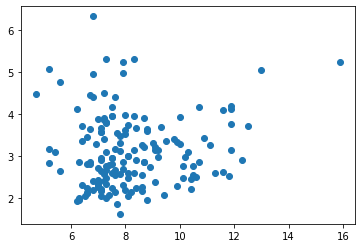

In [383]:
plt.scatter(X_tensor[:, 0],std)

### Use SCOD on test set

In [3]:
features = red_wine.drop('quality', axis=1).values
targets = red_wine['quality'].values.reshape(-1, 1)

In [4]:
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(targets, dtype=torch.float32)

In [6]:
X_tensor_train = X_tensor[:int(0.8*len(X_tensor))]
y_tensor_train = y_tensor[:int(0.8*len(y_tensor))]
X_tensor_test = X_tensor[int(0.8*len(X_tensor)):]
y_tensor_test = y_tensor[int(0.8*len(y_tensor)):]

In [8]:
dataset_test = torch.utils.data.TensorDataset(X_tensor_test, y_tensor_test)

In [9]:
dataset_size = dataset_train.tensors[0].shape[1]

In [10]:
meanvar_model = torch.nn.Sequential(
    torch.nn.Linear(dataset_size, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 2)
)
meanvar_dist_layer = scod.distributions.NormalMeanDiagVarParamLayer()
model = torch.nn.Sequential(meanvar_model, meanvar_dist_layer)

In [11]:
# check parameters of meanvar_unc_model
meanvar_unc_model = scod.SCOD(meanvar_model, args={
    'num_eigs': 10,
    'num_samples': 64, # check number of samples  
    'sketch_type': 'srft',
})

Weight space dimension: 1.150e+04


In [15]:
print("Shape of dataset_test:", dataset_test.shape)

AttributeError: 'TensorDataset' object has no attribute 'shape'

In [16]:
print("Type of dataset_test:", type(dataset_test))

Type of dataset_test: <class 'torch.utils.data.dataset.TensorDataset'>


In [12]:
meanvar_unc_model.process_dataset(dataset_test, meanvar_dist_layer)

computing basis
using T = 64


  0%|          | 0/320 [00:00<?, ?it/s]

C:\Users\Kelyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [13]:
settings = [
    {   
        'name': 'ReLU MeanVar output',
        'model': meanvar_unc_model,
        'dist_layer': meanvar_dist_layer,
    },
]

In [14]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(X_tensor_test) 
    
    marg_dist = meanvar_dist_layer.marginalize_gaussian(z_mean, z_var)
    z_var = z_var[:,:1]

    _, z_prior_var = scod_model(X_tensor_test, use_prior=True) # from test dataset

    marg_prior_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_prior_var)
    z_prior_var = z_prior_var[:,:1]

    z_mean_dataset, _ = scod_model(X_tensor_test)
    z_mean_dataset = z_mean_dataset[:,:1]
    sq_err = (y_tensor_test - z_mean_dataset)**2

    result = {
        'name': setting['name'],
        'z_vars': z_var.detach().cpu().numpy().reshape(X_tensor_test.shape[0]),
        'total_var': marg_dist.variance.detach().cpu().numpy().reshape(X_tensor_test.shape[0]),
        'prior_z_vars': z_prior_var.detach().cpu().numpy().reshape(X_tensor_test.shape[0]),
        'total_prior_var': marg_prior_dist.variance.detach().cpu().numpy().reshape(X_tensor_test.shape[0]),
        'sq_err' : sq_err.detach().cpu().numpy()
    }
    
    results.append(result)

In [404]:
features_list = red_wine.columns[:-1].tolist()

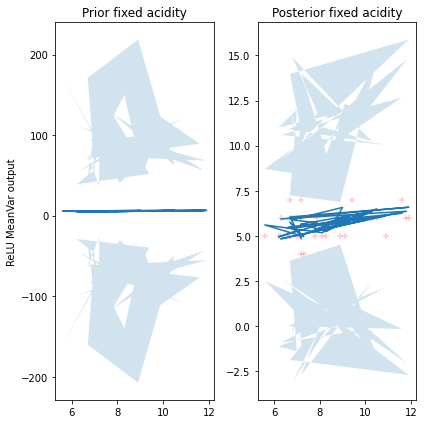

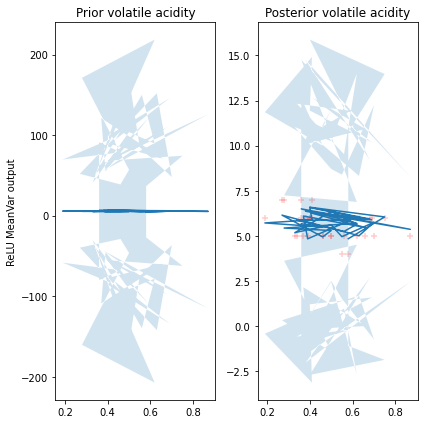

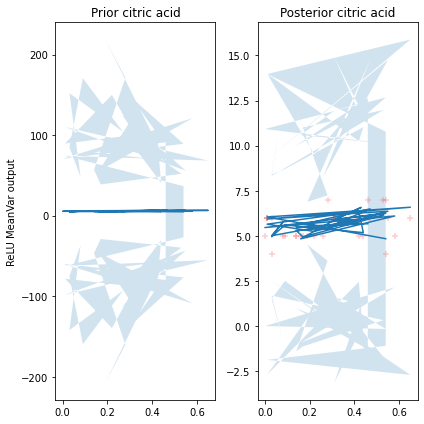

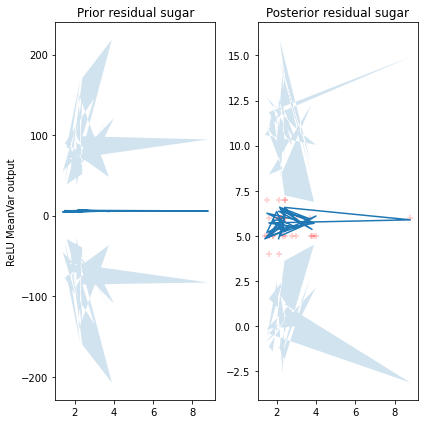

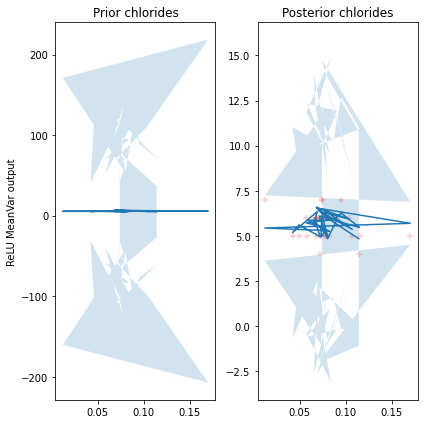

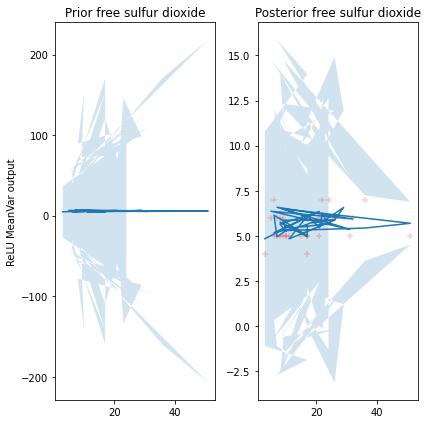

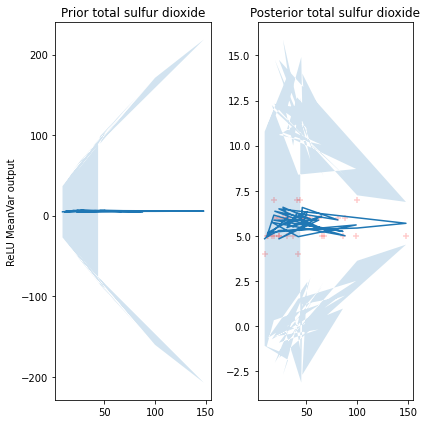

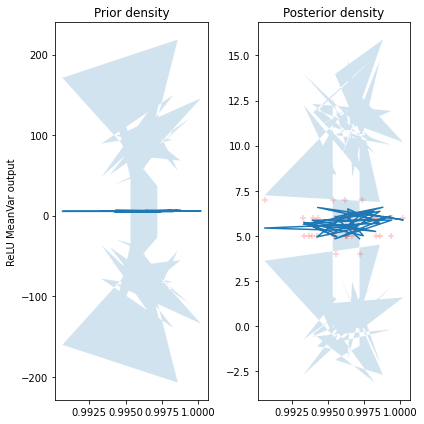

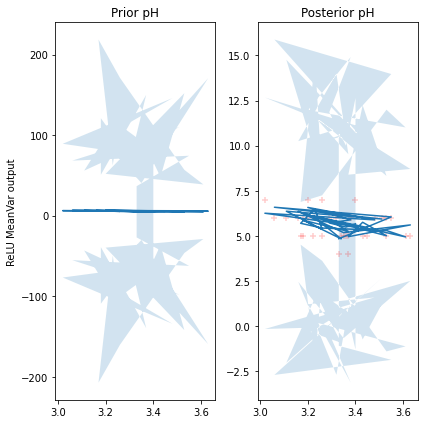

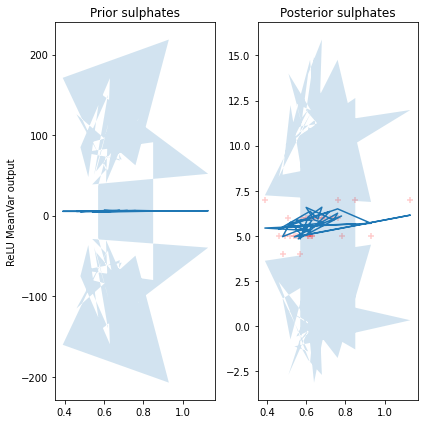

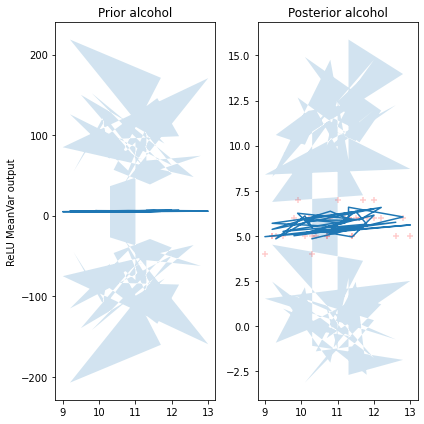

In [406]:
for i in range(len(features_list)):
    X_1dd = X_tensor_test[:, i]
    feature = features_list[i]
    fig, axes = plt.subplots(len(results), 2, figsize=[6,6])

    draw_y = True

    for i, result in enumerate(results):
        std = np.sqrt(result['total_prior_var'])
        axes[0].fill_between(X_1dd, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
        axes[0].plot(X_1dd, draw_y*yhat)
        std = np.sqrt(result['total_var'])
        axes[1].fill_between(X_1dd, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
        axes[1].plot(X_1dd, draw_y*yhat)
        axes[1].scatter(X_1dd, draw_y*y_tensor_test, marker='+', alpha=0.2, color='red')
        
        axes[0].set_ylabel(result['name'])

    axes[0].set_title('Prior ' + feature)
    axes[1].set_title('Posterior '+ feature)

    plt.tight_layout()

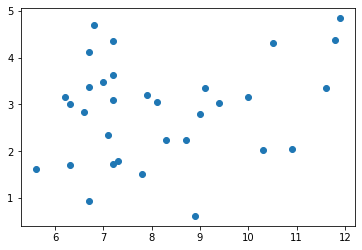

In [408]:
plt.scatter(X_tensor_test[:, 0], np.sqrt(result['total_var']))

Text(0.5, 1.0, 'Quality vs. Uncertainty')

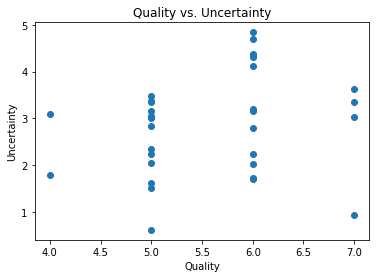

In [416]:
plt.scatter(y_tensor_test, np.sqrt(result['total_var']))
# set x label
plt.xlabel('Quality')
# set y label
plt.ylabel('Uncertainty')
# set title
plt.title('Quality vs. Uncertainty')
# draw a curve that represents the mean of the uncertainty accross the quality

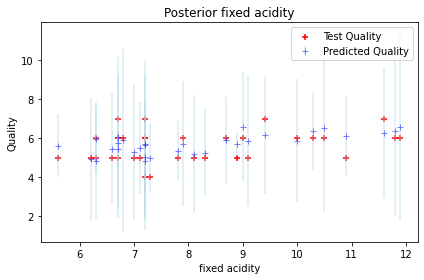

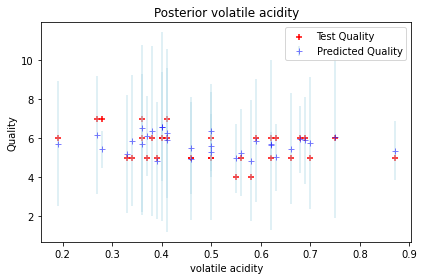

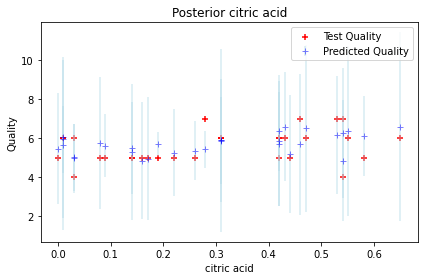

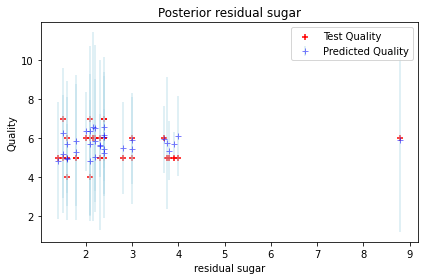

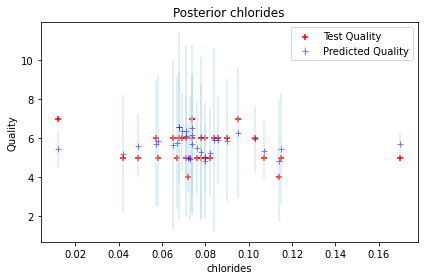

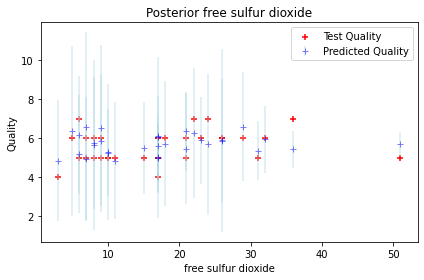

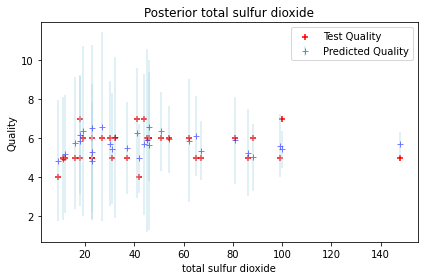

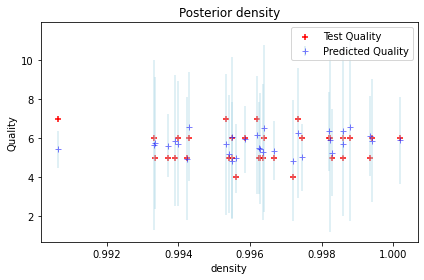

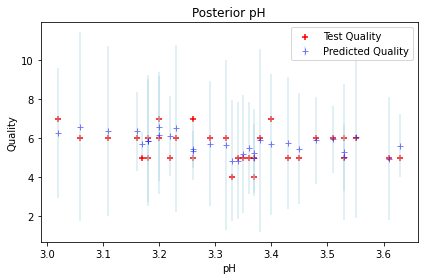

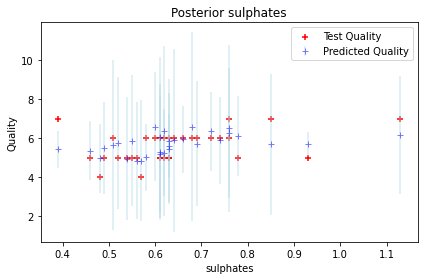

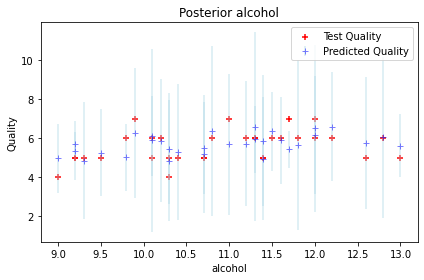

In [435]:
for i in range(len(features_list)):
    # create a plot
    fig, ax = plt.subplots()
    X_1dd = X_tensor_test[:, i]
    feature = features_list[i]
    draw_y = True

    for i, result in enumerate(results):
        std = np.sqrt(result['total_var'])
        # ax.fill_between(X_1dd, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
        # use std as the error bar for each point yhat
        # ax.scatter(X_1dd, draw_y*yhat, yerr=std, marker="+", color="blue", label="Predicted Quality")
        ax.errorbar(X_1dd, yhat, yerr=std, fmt='+', color='blue', alpha = 0.5, ecolor='lightblue',label='Predicted Quality')
        ax.scatter(X_1dd, draw_y*y_tensor_test, marker='+', color='red', label = "Test Quality")
    ax.set_title('Posterior '+ feature)
    # set y label
    ax.set_ylabel('Quality')
    ax.set_xlabel(feature)
    plt.legend()

    plt.tight_layout()

In [441]:
y_tensor_test = y_tensor_test.flatten()

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_23024\1682921081.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yhat = torch.tensor(yhat)


(0.003224842845158532, 0.9860244240068402)


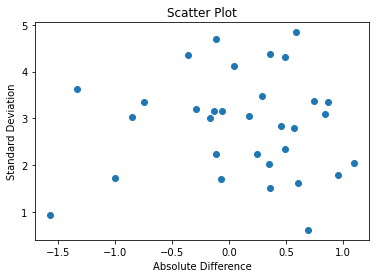

In [451]:
for i, result in enumerate(results):
        std = np.sqrt(result['total_var'])
        # Calculate the absolute difference between yhat and y_tensor_test
        # transform y_tensor_test to 1D array
        # transform yhat to a tensor
        yhat = torch.tensor(yhat)
        abs_diff = yhat - y_tensor_test
        # Plot the scatter plot
        # compute correlation between abs_diff and std
        corr = pearsonr(abs_diff, std)
        print(corr)
        plt.scatter(abs_diff, std)
        plt.xlabel('Absolute Difference')
        plt.ylabel('Standard Deviation')
        plt.title('Scatter Plot')
        plt.show()


##### Computing NLL Loss

In [454]:
for i, result in enumerate(results):
        variance = result['total_var']
        # transform variance to a tensor
        variance = torch.tensor(variance)
        nll_loss = 0.5 * torch.log(2 * torch.pi * variance) + (y_tensor_test - yhat) ** 2 / (2 * variance)
        nll_loss = nll_loss.mean()

print(f'Negative Log Likelihood Loss on the Test Set of the Wine Dataset using SCOD: {nll_loss.item()}')

Negative Log Likelihood Loss on the Test Set of the Wine Dataset using SCOD: 1.978954792022705
